In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
import random
import time

In [2]:
import os
import sys
sys.path.append("../codes")

In [3]:
from maml_utils import loss_function, np_to_tensor, compute_loss, compute_gradients, apply_gradients, train_batch, copy_model, eval_sine_test

In [4]:
# next two functions are for plotting
def update_k(x_new, x_c, kernel):
    """
    This function returns the posterior standard deviation of a GP

    Takes as input: 
    x_new - points we want to evaluate the new kernel at
    x_c - points we have already evaluated
    kernel - the kernel of the prior

    returns:
    The standard deviation of the posterior at the points x_new
    """
    K = kernel(x_c)
    inv_K = np.linalg.inv(K)

    kx = kernel(x_c, x_new)
    out = np.dot(kx.T, np.dot(inv_K, kx))
    
    n = len(x_new)

    out2 = np.zeros(n)

    for i in range(n):
        kx2 = kernel(x_c, x_new[i].reshape(-1, 1))
        out2[i] = np.dot(kx2.T, np.dot(inv_K, kx2))
        
    print(np.abs(np.diag(out) - out2).max())
    
    k_xx = kernel(x_new)

    return (k_xx - out)

def update_mean(x_new, x_c, y_c, kernel):
    """
    This function returns the posterior standard deviation of a GP

    Takes as input: 
    x_new - points we want to evaluate the new kernel at
    x_c - points we have already evaluated
    y_c - observed points
    kernel - the kernel of the prior

    returns:
    The mean of the posterior at the points x_new
    """

    K = kernel(x_c.reshape(-1, 1))
    inv_K = np.linalg.inv(K)

    n = len(x_new)

    out = np.zeros(n)

    y_m = y_c # - mean_fn(x_c).reshape(-1, 1)

    for i in range(n):
        kx = kernel(x_c, x_new[i].reshape(-1, 1))
        out[i] = np.dot(kx.T, np.dot(inv_K, y_m))

    return out.reshape(-1)

In [46]:
from dataset import Generator, Dataset
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Matern
import scipy
import random
from functools import partial

class GaussianProcessGenerator(Generator):
    
    def __init__(self, *args, n_samples=100, sample_x_uniform=True, parameters=None, **kwargs):
        self.n_samples = n_samples if parameters is None or 'n_samples' not in parameters else parameters['n_samples'] 
        self.sample_x_uniform = sample_x_uniform if parameters is None or 'sample_x_uniform' not in parameters else parameters['sample_x_uniform'] 
        self.kernel = 0.75 * Matern(length_scale=1, nu = 2.5) # GP kernel
        super().__init__(*args, parameters=parameters, **kwargs)

    def _sample_parameters(self, x_obs=None, y_obs=None):
        parameters = {}
        xs = np.linspace(-2, 2, self.n_samples) if self.sample_x_uniform else np.random.uniform(-2, 2, self.n_samples)
        xs = xs.reshape((-1,1))
        if x_obs is None or y_obs is None:
            mean = np.zeros(self.n_samples)
            cov = self.kernel(xs)
        else:
            for x_ in x_obs.flatten():
                if x_ not in xs.flatten():
                    xs = np.vstack([xs, x_])
            x_obs = x_obs.reshape((-1,1))
            y_obs = y_obs.reshape((-1,1))
            mean = update_mean(xs, x_obs, y_obs, self.kernel)
            cov = update_k(xs, x_obs, self.kernel)
            
        ys = scipy.stats.multivariate_normal.rvs(mean = mean, cov = cov, size = 1)
        parameters['f'] = {x: y for x,y in zip(xs.flatten(),ys.flatten())}
        parameters['means'] = {x: m for x,m in zip(xs.flatten(),mean.flatten())}
        parameters['stds'] = {x: s for x,s in zip(xs.flatten(),np.sqrt(np.diag(cov)).flatten())}
        parameters['n_samples'] = self.n_samples
        parameters['sample_x_uniform'] = self.sample_x_uniform
        return parameters
    
    def update(self, x_obs=None, y_obs=None):
        self.parameters = self._sample_parameters(x_obs=x_obs, y_obs=y_obs)

    def _sample_x(self):
        return np.array(random.sample(list(self.parameters['f'].keys()), self.K))

    def equally_spaced_samples(self, K=None):
        if K is None:
            K = self.K
        return np.linspace(-2, 2, K)

    def f(self, x, on='f'):
        return np.array([self.parameters[on][x_] for x_ in x])
    
    def batch(self, x=None, force_new=False, on='f'):
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x, on=on)
        return x[:, None], y[:, None]

class GaussianProcessDataset(Dataset):
    def __init__(self, n_samples=100, sample_x_uniform=True, **kwargs):
        assert 'generator' not in kwargs
        generator_class = partial(GaussianProcessGenerator, n_samples=n_samples, sample_x_uniform=sample_x_uniform)
        super().__init__(generator_class=generator_class, **kwargs)

General Trainer class

In [51]:
class Trainer():
    
    def __init__(self, model):
        self.model = model
        
    def train(dataset_train):
        raise NotImplementedError
        
    def evaluate(dataset_test):
        raise NotImplementedError
        
    def save(path):
        raise NotImplementedError

Model

In [52]:
class Model(keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40, input_shape=(40,))
        self.out = keras.layers.Dense(1, input_shape=(40,))
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x
    
    def call(self, x):
        return self.forward(x)

Trainer

In [53]:
def split_context_target(xs, ys, n_context):
    """Randomly split a set of x,y samples into context and target sets"""
    context_mask = np.zeros(xs.shape[0], dtype=bool)
    context_mask[[i for i in random.sample(range(xs.shape[0]), n_context)]] = True

    context_xs = xs[context_mask]
    context_ys = ys[context_mask]

    target_xs = xs[~context_mask]
    target_ys = ys[~context_mask]

    return context_xs, context_ys, target_xs, target_ys

In [73]:
class MAMLTrainer(Trainer):

    def __init__(self, model, model_class=Model):
        self.model_class = model_class
        self.model = model
        x, _ = np_to_tensor([np.ones((10,1)), np.ones((10,1))])
        self.model.forward(x)
        
    def train(self, dataset_train, n_epochs=1, n_iter=100, min_context=1, max_context=10, lr_inner=0.01, batch_size=1, log_steps=1000):
        optimizer = keras.optimizers.Adam()
    
        # Step 2: instead of checking for convergence, we train for a number
        # of epochs
        losses = []
        test_losses_all = []
        test_losses_epoch = []
        for e in range(n_epochs):
            total_loss = 0
            start = time.time()
            # Step 3 and 4
            for i, t in enumerate(dataset_train(size=n_iter)):
                x, y = np_to_tensor(t.batch())
                n_context = random.choice(range(min_context, max_context+1))
                context_x, context_y, target_x, target_y = split_context_target(x, y, n_context)
                
                with tf.GradientTape() as test_tape:
                    # test_tape.watch(model.trainable_variables)
                    # Step 5
                    with tf.GradientTape() as train_tape:
                        train_loss, _ = compute_loss(self.model, context_x, context_y)
                    # Step 6
                    gradients = train_tape.gradient(train_loss, self.model.trainable_variables)
                    k = 0
                    model_copy = copy_model(self.model, context_x, model_class=self.model_class)
                    for j in range(len(model_copy.layers)):
                        model_copy.layers[j].kernel = tf.subtract(self.model.layers[j].kernel,
                                    tf.multiply(lr_inner, gradients[k]))
                        model_copy.layers[j].bias = tf.subtract(self.model.layers[j].bias,
                                    tf.multiply(lr_inner, gradients[k+1]))
                        k += 2
                    # Step 8
                    test_loss, logits = compute_loss(model_copy, target_x, target_y)
                    test_losses_all.append(test_loss.numpy())
                # Step 8
                gradients = test_tape.gradient(test_loss, self.model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

                # Logs
                total_loss += test_loss
            test_losses_epoch.append(test_loss.numpy())
            loss = total_loss / n_iter
            losses.append(loss.numpy())

            print('Epoch {}: mean loss = {}, Time to run {} steps = {}'.format(e, loss, n_iter, time.time() - start))
            start = time.time()
            print(losses)
        plt.plot(losses)
        plt.show()
        
        plt.plot(test_losses_all)
        plt.show()
        
        plt.plot(test_losses_epoch)
        plt.show()
            
    def save(self, path):
        self.model.save_weights(path)
        
    def load(self, path):
        self.model.built = True
        self.model.load_weights(path)
            
    def evaluate(self, generator_test, x_obs=None, y_obs=None, **kwargs):
        
        fit_res_all = []
        for index in range(1, x_obs.size+1):
            
            x, y = x_obs[:index].reshape((-1,1)), y_obs[:index].reshape((-1,1))
            generator_test.update(x_obs=x, y_obs=y)
            x_test = generator_test.equally_spaced_samples(K=200).reshape((-1,1))
            x_test, y_test = generator_test.batch(x=x_test.flatten(), on='means')
            _, stds_test = generator_test.batch(x=x_test.flatten(), on='stds')
            
            plt.plot(x, y, 'ro')
            plt.plot(x_test, y_test)
            plt.show()
        
            print('Number of context points {}'.format(index))
            fit_res = self.eval_sinewave_for_test(x[:index], y[:index], x_test, y_test, stds_test, **kwargs)
            print('Loss :', fit_res[-1][-1])
            fit_res_all.append(fit_res)
        return fit_res_all
        
        
        
        
    def eval_sinewave_for_test(self, x, y, x_test, y_test, stds_test, num_steps=(10,), lr=0.01, plot=True):
        '''Evaluates how the sinewave addapts at dataset.

        The idea is to use the pretrained model as a weight initializer and
        try to fit the model on this new dataset.

        Args:
            model: Already trained model.
            sinusoid_generator: A sinusoidGenerator instance.
            num_steps: Number of training steps to be logged.
            lr: Learning rate used for training on the test data.
            plot: If plot is True than it plots how the curves are fitted along
                `num_steps`.

        Returns:
            The fit results. A list containing the loss, logits and step. For
            every step at `num_steps`.
        '''

        # copy model so we can use the same model multiple times
        copied_model = copy_model(self.model, x, model_class=self.model_class)

        # use SGD for this part of training as described in the paper
        optimizer = keras.optimizers.SGD(learning_rate=lr)

        # run training and log fit results
        fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)

        # plot
        train, = plt.plot(x, y, '^')
        ground_truth, = plt.plot(x_test, y_test)
        plt.fill_between(x_test.reshape(-1), y_test.reshape(-1) - 1.96*stds_test.reshape(-1), y_test.reshape(-1) + 1.96*stds_test.reshape(-1), "r", label = "_nolegend_", alpha = 0.2)
        plots = [train, ground_truth]
        legend = ['Training Points', 'True Function']
        for n, res, loss in fit_res:
            cur, = plt.plot(x_test, res[:, 0], '--')
            plots.append(cur)
            legend.append(f'After {n} Steps')
        plt.legend(plots, legend)
        plt.ylim(-1.5, 1.5)
        plt.xlim(-2.5, 2.5)
        if plot:
            plt.show()

        return fit_res
        
        
    
    

In [74]:
model = Model()
trainer = MAMLTrainer(model)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
trainer.train(GaussianProcessDataset, n_epochs=200)

In [ ]:
trainer.save('../outputs/gp.tf')

In [75]:
trainer.load('../outputs/gp.tf')

In [78]:
dataset_test = GaussianProcessDataset(size=1, K=5, n_samples=200)
generator_test = dataset_test[0]
obs = [(-1.9, 0.4264), (-1.2, -0.3638), (-0.3, 0.1630), (0.7, 1.0264), (1.5, 0.9203)]
x_obs = np.array([pair[0] for pair in obs])
y_obs = np.array([pair[1] for pair in obs])

0.0


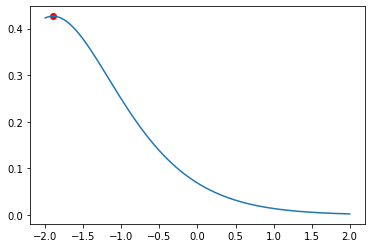

Number of context points 1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/home/oscar/miniconda3/envs/p1025_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [-2.0 -1.979899497487437 -1.9597989949748744 -1.9396984924623115
 -1.9195979899497488 -1.899497487437186 -1.879396984924623
 -1.8592964824120604 -1.8391959798994975 -1.8190954773869348
 -1.7989949748743719 -1.778894472361809 -1.7587939698492463
 -1.7386934673366834 -1.7185929648241207 -1.6984924623115578
 -1.678391959798995 -1.6582914572864322 -1.6381909547738693
 -1.6180904522613067 -1.5979899497487438 -1.5778894472361809
 -1.557788944723618 -1.5376884422110553 -1.5175879396984926
 -1.4974874371859297 -1.4773869346733668 -1.457286432160804
 -1.4371859296482412 -1.4170854271356785 -1.3969849246231156
 -1.3768844221105527 -1.3567839195979898 -1.3366834170854272
 -1.3165829145728645 -1.2964824120603016 -1.2763819095477387
 -1.2562814070351758 -1.236180904522613 -1.2160804020100502
 -1.1959798994974875

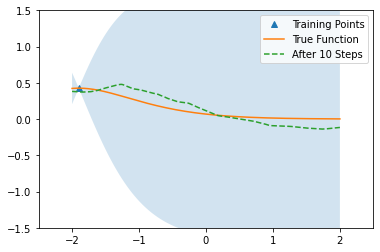

Loss : tf.Tensor(0.01121722055065098, shape=(), dtype=float64)
2.220446049250313e-16


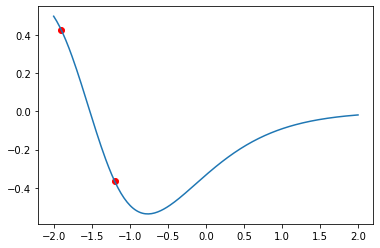

Number of context points 2

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/home/oscar/miniconda3/envs/p1025_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [-2.0 -1.979899497487437 -1.9597989949748744 -1.9396984924623115
 -1.9195979899497488 -1.899497487437186 -1.879396984924623
 -1.8592964824120604 -1.8391959798994975 -1.8190954773869348
 -1.7989949748743719 -1.778894472361809 -1.7587939698492463
 -1.7386934673366834 -1.7185929648241207 -1.6984924623115578
 -1.678391959798995 -1.6582914572864322 -1.6381909547738693
 -1.6180904522613067 -1.5979899497487438 -1.5778894472361809
 -1.557788944723618 -1.5376884422110553 -1.5175879396984926
 -1.4974874371859297 -1.4773869346733668 -1.457286432160804
 -1.4371859296482412 -1.4170854271356785 -1.3969849246231156
 -1.3768844221105527 -1.3567839195979898 -1.3366834170854272
 -1.3165829145728645 -1.2964824120603016 -1.2763819095477387
 -1.2562814070351758 -1.236180904522613 -1.2160804020100502
 -1.1959798994974875

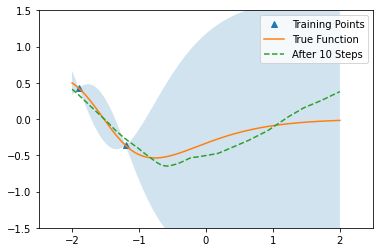

Loss : tf.Tensor(0.02436993324516576, shape=(), dtype=float64)
3.3306690738754696e-16


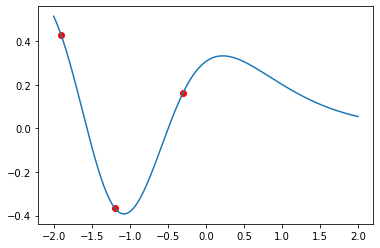

Number of context points 3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/home/oscar/miniconda3/envs/p1025_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [-2.0 -1.979899497487437 -1.9597989949748744 -1.9396984924623115
 -1.9195979899497488 -1.899497487437186 -1.879396984924623
 -1.8592964824120604 -1.8391959798994975 -1.8190954773869348
 -1.7989949748743719 -1.778894472361809 -1.7587939698492463
 -1.7386934673366834 -1.7185929648241207 -1.6984924623115578
 -1.678391959798995 -1.6582914572864322 -1.6381909547738693
 -1.6180904522613067 -1.5979899497487438 -1.5778894472361809
 -1.557788944723618 -1.5376884422110553 -1.5175879396984926
 -1.4974874371859297 -1.4773869346733668 -1.457286432160804
 -1.4371859296482412 -1.4170854271356785 -1.3969849246231156
 -1.3768844221105527 -1.3567839195979898 -1.3366834170854272
 -1.3165829145728645 -1.2964824120603016 -1.2763819095477387
 -1.2562814070351758 -1.236180904522613 -1.2160804020100502
 -1.1959798994974875

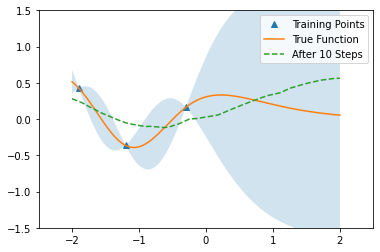

Loss : tf.Tensor(0.06462981115491147, shape=(), dtype=float64)
6.661338147750939e-16


/home/oscar/miniconda3/envs/p1025_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


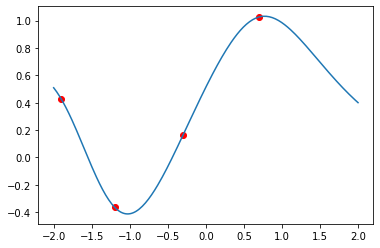

Number of context points 4

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/home/oscar/miniconda3/envs/p1025_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [-2.0 -1.979899497487437 -1.9597989949748744 -1.9396984924623115
 -1.9195979899497488 -1.899497487437186 -1.879396984924623
 -1.8592964824120604 -1.8391959798994975 -1.8190954773869348
 -1.7989949748743719 -1.778894472361809 -1.7587939698492463
 -1.7386934673366834 -1.7185929648241207 -1.6984924623115578
 -1.678391959798995 -1.6582914572864322 -1.6381909547738693
 -1.6180904522613067 -1.5979899497487438 -1.5778894472361809
 -1.557788944723618 -1.5376884422110553 -1.5175879396984926
 -1.4974874371859297 -1.4773869346733668 -1.457286432160804
 -1.4371859296482412 -1.4170854271356785 -1.3969849246231156
 -1.3768844221105527 -1.3567839195979898 -1.3366834170854272
 -1.3165829145728645 -1.2964824120603016 -1.2763819095477387
 -1.2562814070351758 -1.236180904522613 -1.2160804020100502
 -1.1959798994974875

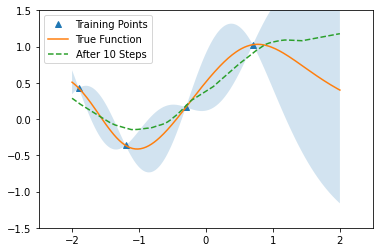

Loss : tf.Tensor(0.07442383420285471, shape=(), dtype=float64)


/home/oscar/miniconda3/envs/p1025_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


6.661338147750939e-16


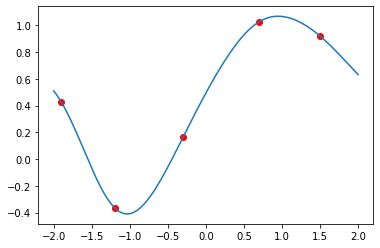

Number of context points 5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/home/oscar/miniconda3/envs/p1025_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [-2.0 -1.979899497487437 -1.9597989949748744 -1.9396984924623115
 -1.9195979899497488 -1.899497487437186 -1.879396984924623
 -1.8592964824120604 -1.8391959798994975 -1.8190954773869348
 -1.7989949748743719 -1.778894472361809 -1.7587939698492463
 -1.7386934673366834 -1.7185929648241207 -1.6984924623115578
 -1.678391959798995 -1.6582914572864322 -1.6381909547738693
 -1.6180904522613067 -1.5979899497487438 -1.5778894472361809
 -1.557788944723618 -1.5376884422110553 -1.5175879396984926
 -1.4974874371859297 -1.4773869346733668 -1.457286432160804
 -1.4371859296482412 -1.4170854271356785 -1.3969849246231156
 -1.3768844221105527 -1.3567839195979898 -1.3366834170854272
 -1.3165829145728645 -1.2964824120603016 -1.2763819095477387
 -1.2562814070351758 -1.236180904522613 -1.2160804020100502
 -1.1959798994974875

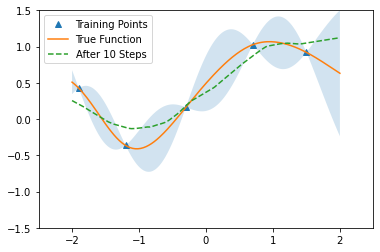

Loss : tf.Tensor(0.03553361637121027, shape=(), dtype=float64)


In [81]:
fit_res_all = trainer.evaluate(generator_test, x_obs=x_obs, y_obs=y_obs)

In [83]:
ys=fit_res_all[1][0][1].numpy()

In [84]:
np.save('gp_maml', ys)